<a href="https://colab.research.google.com/github/baolongyizu/-baolongyizu-.github.io/blob/master/Investment_Analysis_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*italicized text*

Out of sample data ranging from 2016 to 2020


In [155]:
pip install PyPortfolioOpt

In [156]:
from google.colab import files 

In [157]:
uploaded = files.upload()

Saving hw3_data.csv to hw3_data (2).csv


In [158]:
import io 
import pandas as pd
import seaborn as sns
import numpy as np  
import matplotlib.pyplot as plt  
import cvxopt as opt  
from cvxopt import blas, solvers  
from pypfopt.efficient_frontier import EfficientFrontier
%matplotlib inline

df = pd.read_csv(io.BytesIO(uploaded['hw3_data.csv']),index_col="Date") 

Data cleaning for future calculations

In [ ]:
df_fiveyear = df[:60] # slice first five year data
df_af = df[60:129]
df_norf_five = df_fiveyear.drop(['rf'], axis = 1) # df for five years without risk free rate
df_norf= df.drop(['rf'], axis = 1) # df for all years without risk free rate
df_norf_af = df_norf[60:129] # back test data


In [159]:
df_norf.head()

,AGG,IVV,IYF,IYZ,IYH,IYG,IYC
Date,,,,,,,
1/31/2010,0.014149,-0.037117,-0.016030,-0.089910,0.005641,-0.010240,-0.023608
2/28/2010,0.001985,0.031488,0.031403,0.026894,0.004051,0.024266,0.047988
3/31/2010,-0.000067,0.061121,0.087978,0.077886,0.032352,0.089330,0.076066
4/30/2010,0.009732,0.016192,0.019982,0.017982,-0.031212,0.019069,0.036733
5/31/2010,0.010825,-0.080007,-0.090737,-0.038273,-0.071751,-0.105647,-0.057418


In [160]:
rf = (df.mean()*12)['rf']
rf_five = (df_fiveyear.mean()*12)['rf']
rf_af = (df_af.mean()*12)['rf']

In [161]:
rf_five

0.000610000176

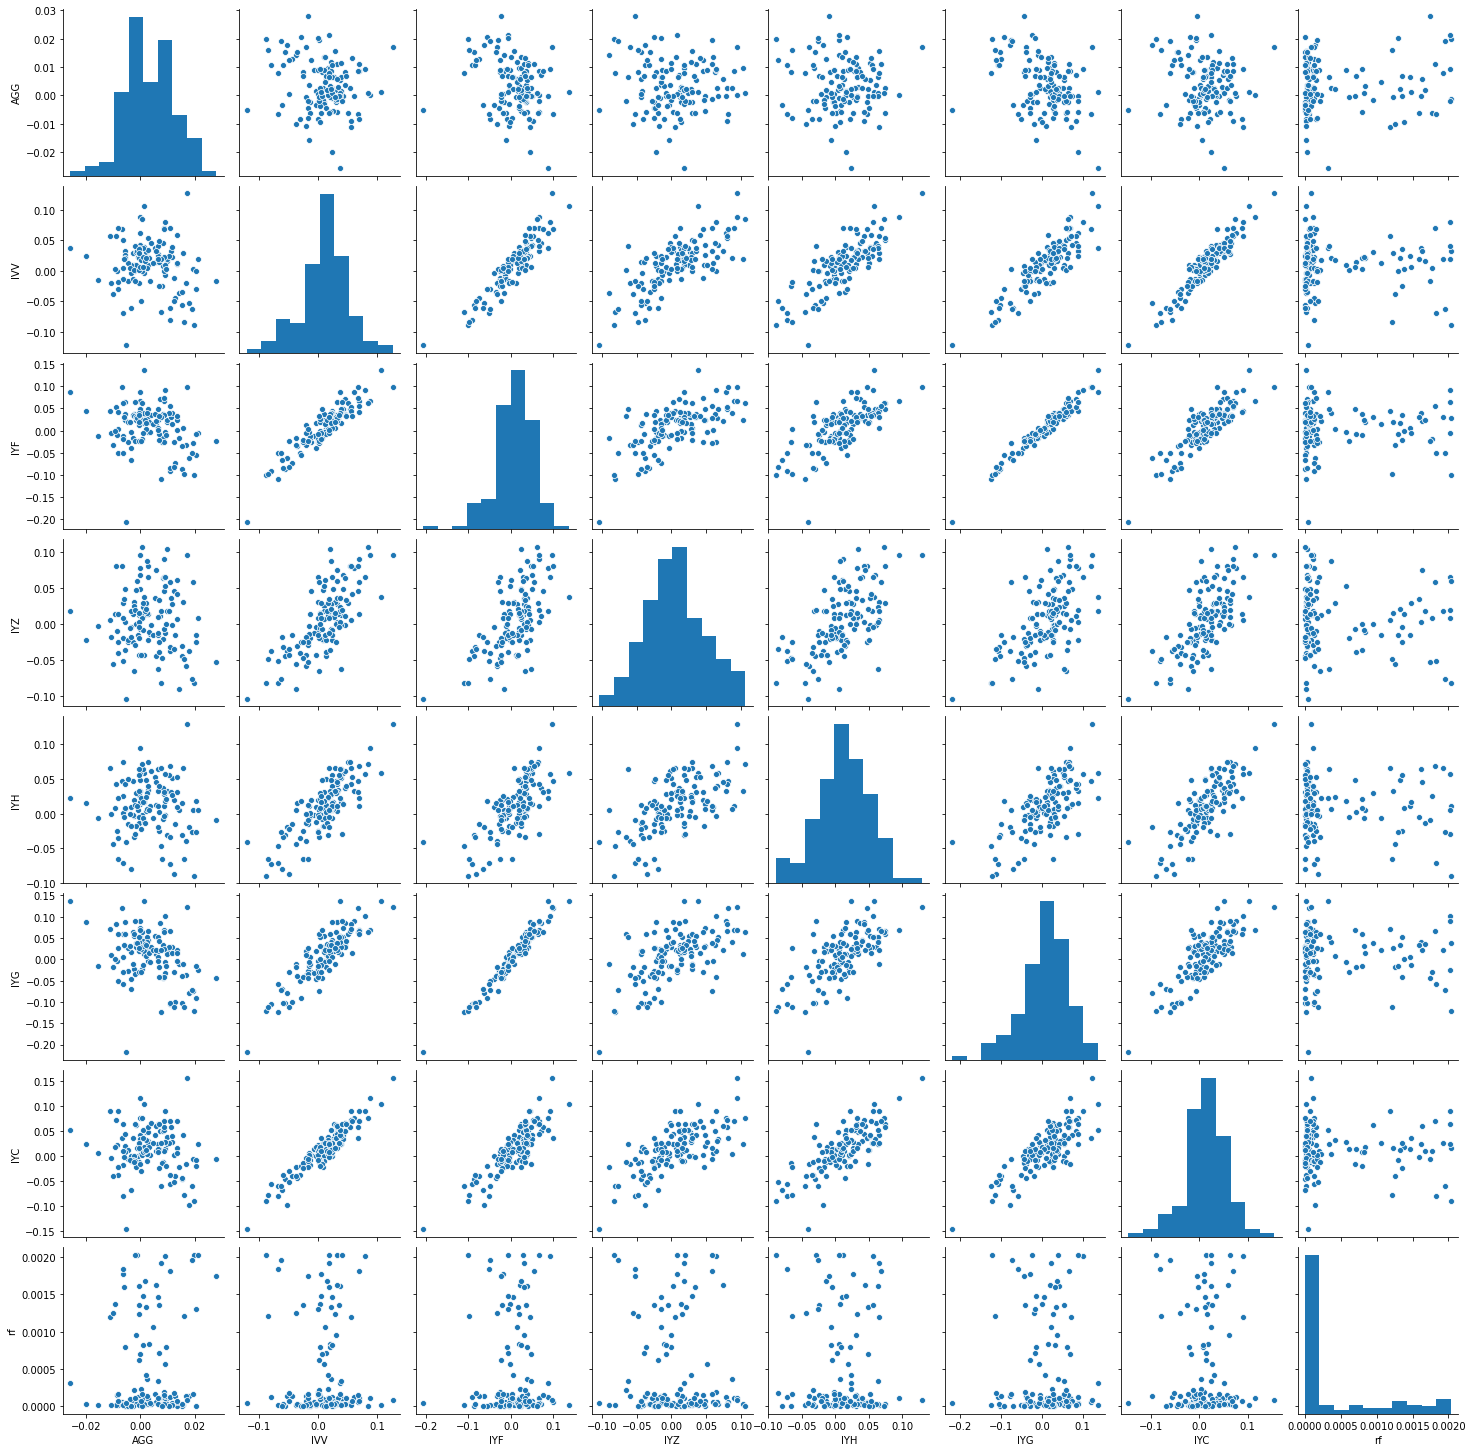

In [ ]:
sns.pairplot(df)

In [ ]:
sns.pairplot(df_fiveyear)

In [ ]:
df.head()

,AGG,IVV,IYF,IYZ,IYH,IYG,IYC,rf
Date,,,,,,,,
1/31/2010,0.014149,-0.037117,-0.016030,-0.089910,0.005641,-0.010240,-0.023608,0.000017
2/28/2010,0.001985,0.031488,0.031403,0.026894,0.004051,0.024266,0.047988,0.000075
3/31/2010,-0.000067,0.061121,0.087978,0.077886,0.032352,0.089330,0.076066,0.000125
4/30/2010,0.009732,0.016192,0.019982,0.017982,-0.031212,0.019069,0.036733,0.000117
5/31/2010,0.010825,-0.080007,-0.090737,-0.038273,-0.071751,-0.105647,-0.057418,0.000125


A function to simulate the weight assigned for the portfoli

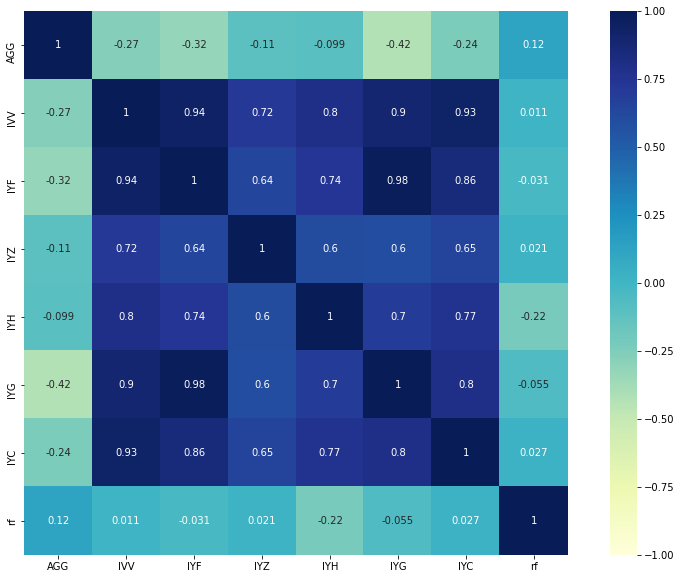

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df_fiveyear.corr(),cmap="YlGnBu", vmin = -1, vmax = 1, square = True, annot = True)

In [ ]:
import plotly.graph_objs as go
fig = go.Figure([{
    'x': df_fiveyear.index,
    'y': df_fiveyear[col],
    'name': col
}  for col in df.columns])

In [ ]:
fig.show()

In [162]:
class SimulatePortfolio(object):
    def __init__(self, dataframe, riskfree):
        self.returns = dataframe
        self.expectedReturn = [(riskfree + i*0.01) for i in range(16)]

    def getExpectedReturn(self):
        return self.expectedReturn

    def setExpectedReturn(self, newReturn):
        self.expectedReturn = newReturn

    def rand_weights(self,n):  
            ''' Produces n random weights that sum to 1 '''  
            k = np.random.rand(n)  
            return k / sum(k)

    def random_portfolio(self):  
        '''  
        Returns the mean and standard deviation of returns for a random portfolio
        @param: returns, the mean and standard deviation of the returns  
        '''
        r_horizontal = self.returns.T
        randWeight = self.rand_weights(r_horizontal.shape[0])
        # print("random weight:", randWeight)
        p = np.asmatrix(np.mean(r_horizontal, axis=1))  # scale to annual
        w = np.asmatrix(randWeight)  
        C = np.asmatrix(np.cov(r_horizontal))
        mu = w * p.T * 12   
        # print("random return:", mu)
        sigma = np.sqrt(np.dot(np.dot(w,C), w.T) * 12)
        # print("sigma:", sigma)
        # # This recursion reduces outliers to keep plots pretty  
        # if sigma > 2:  
        #     return random_portfolio(self.returns)  
        return mu, sigma

    def simulatePortfolio(self):
      """
      Return simulated means and stds in column set
      @param returnInput: input montly return data
      """
      n_portfolios = 50000  
      means, stds = np.column_stack([  
          self.random_portfolio()  
          for _ in range(n_portfolios)  
      ])
      return means, stds

    def plotSimulated(self, titleString, SBT = None):
      """
      Simulate the portfolio with input
      @param expectedStd, calculated standard deviation
      @param titleString, tital string to represent the title
      """
      mean, std = self.simulatePortfolio()
      plt.style.use('fivethirtyeight')
      plt.figure(figsize=(20,10))
      plt.plot(std, mean, 'o', markersize=5, label = 'Simulated') 
      if(not (SBT is None) ):
        plt.plot(SBT.SNaive, SBT.muNaive, 's', markersize=5, label = "Naive")
        plt.plot(SBT.SMinVar, SBT.muMinVar, 's', markersize=5, label = "MinVariance")
        plt.plot(SBT.SMaxSP, SBT.muMaxSP, 's', markersize=5, label = "MaxSharpe")
        plt.plot(SBT.SRP, SBT.muRP, 's', markersize=5, label = "RiskParity")
        plt.plot(SBT.SSF, SBT.muSF, 's', markersize=5, label = "SixtyForty")
        plt.plot(SBT.stdev_cal, SBT.r_cal, 'rs', markersize=5, label = "CapitalAllocationLine")

      plt.axis([0, 0.2, 0, 0.2])
      plt.xlabel('std')  
      plt.ylabel('mean')
      leg = plt.legend(loc='upper left')
      plt.title(titleString)


In [163]:
class StrategyBackTest(object):

    def __init__(self, returnInput, riskFreeRate):
      self.returnInput = returnInput
      self.expectedReturn = [(riskFreeRate + i*0.01) for i in range(16)]
      self.riskFreeRate = riskFreeRate

      # weight setup
      self.wt_sixtyForty = [0.4, 0.6, 0, 0, 0, 0, 0]
      self.wt_naive = [1/7]*7
      self.wt_maxSP = []
      self.wt_minVar = []
      self.wt_riskParity = []

    def getExpectedReturn(self):
        return self.expectedReturn

    def setExpectedReturn(self, newReturn):
        self.expectedReturn = newReturn
        
    def meanVarianceCal(self):
      """
      Return: annualized return and covariance matrix

      @param: input table of monthly return data

      """
      mu = (self.returnInput.mean()*12).T
      S  = np.asmatrix(np.cov(self.returnInput.T))*12
      return mu, S

    def dToL(self,dict):
      """
        Return list from Dict
        @param: dict from calculated weight of ef model
      """
      returnList = []
      for key in dict.keys():
        returnList.append(dict[key])
      return returnList

    def dictToList(self, dict):
      """
        Return list from Dict
        @param: dict from calculated weight of ef model
      """
      returnList = []
      for key in dict.keys():
        returnList.append(dict[key])
      return np.asmatrix(returnList)


    def exp_portfolio(self,returnInput,weight):  
        '''  
        Returns the mean and standard deviation of returns for a random portfolio  
        '''
        returns = returnInput.T
        p = np.asmatrix(np.mean(returns, axis=1))*12  
        w = np.asmatrix(weight)  
        C = np.asmatrix(np.cov(returns))*12  
        mu = w * p.T  
        sigma = np.sqrt(np.dot(np.dot(w,C), w.T))  
        # # This recursion reduces outliers to keep plots pretty  
        # if sigma > 2:  
        #     return random_portfolio(returns)  
        return mu, sigma

    def calculateSigma(self, ef):
        sigmaList = []
        for ret in self.getExpectedReturn():
          nWeight = ef.efficient_return(ret)
          lWeight = dictToList(nWeight)
          expReturn, expSigma = exp_portfolio(lWeight)
          sigmaList.append(expSigma[0].item())
        return sigmaList

    def riskParityWeight(self):
        """
        Return risk party weight
        @param df: monthly return data
        """
        monthly_std = np.std(self.returnInput, axis = 0, ddof = 1)
        wt_rp = (1/(monthly_std*np.sqrt(12)))/(1/(monthly_std*np.sqrt(12))).sum()
        return wt_rp


    def modelTrain(self):

        mu, S = self.meanVarianceCal() # calculate mean variance
        ef = EfficientFrontier(mu,S)  # get the efficient frontier
        self.wt_maxSP =self.dToL(ef.max_sharpe(risk_free_rate = self.riskFreeRate))
        ef = EfficientFrontier(mu,S)
        self.wt_minVar = self.dToL(ef.min_volatility())
        self.wt_riskParity = self.riskParityWeight()


    def strategySetup(self):

        self.modelTrain()
        strategyDict = {
            "SixtyForty": self.wt_sixtyForty,
            "Naive": self.wt_naive,
            "RiskParity": self.wt_riskParity,
            "MaxSharpe": self.wt_maxSP,
            "MinVariance": self.wt_minVar
        }
        return strategyDict

    def calReturn(self, amt, ann_df, wt):
        sumList = []
        sumList.append(amt) # append the total
        for iter in range(len(ann_df)):
          amt = (ann_df.iloc[iter] * np.asarray(wt)*amt).sum()
          sumList.append(amt)
        return sumList


    def backTest(self, totalAmount, test_df, test_rf):
        """
        Return : A dictionary containing return based on all the strategies
        @param: totalAmount, initial amount to invest
        @param: test_df -> input return period
        """
        strategyDict = self.strategySetup()
        ann_df = 1 + test_df
        resultDict = {}
        for key in strategyDict.keys():
          resultDict[key] = self.calReturn(totalAmount, ann_df, strategyDict[key])
        portfolioRec = pd.DataFrame(resultDict)
        portfolioRec['Period'] =range(0, len(resultDict['Naive']))
        self.length = len(resultDict['Naive'])
        self.portfolioRec = portfolioRec # return is back tested on the test_df

        # self.strategyMeanStd(self.returnInput) # Here might be the problem
        self.strategyMeanStd(test_df) # calculate the strategy average return and std
        sharp = self.calSharpe(test_rf) 
        self.maxSharpe = sharp['MaxSharpe']
        # maxSharpe via 5 year record or via back test result?
        # self.maxSharpe = (self.muMaxSP.item(0) - self.riskFreeRate)/(self.SMaxSP.item(0))
        self.capitalAllocation()

    def plotPortfolio(self, title = "Back Test Result"):
        plt.figure(figsize=(20,10))
        plt.style.use('fivethirtyeight')
        plt.plot('Period','SixtyForty', data=self.portfolioRec, marker='o', markerfacecolor='blue', markersize=5, color='blue', linewidth=4)
        plt.plot('Period','Naive', data=self.portfolioRec, marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=4)
        plt.plot('Period','RiskParity', data=self.portfolioRec, marker='o', markerfacecolor='green', markersize=5, color='green', linewidth=4)
        plt.plot('Period','MaxSharpe', data=self.portfolioRec, marker='o', markerfacecolor='orange', markersize=5, color='orange', linewidth=4)
        plt.plot('Period','MinVariance', data=self.portfolioRec, marker='o', markerfacecolor='purple', markersize=5, color='purple', linewidth=4)
        plt.title(title)
        plt.legend(loc='upper left')

    def calSharpe(self, riskFreeRate):
        """
        Return the calculated sharpe ratio for each strategy with back tested data
        All values are calculated with back test result

        """
        returnMatrix = self.portfolioRec.pct_change()[1: self.length].drop(['Period'], axis = 1)
        return ((returnMatrix.mean()*12- riskFreeRate)/(returnMatrix.std()*np.sqrt(12)))

    def strategyMeanStd(self,test_df):
        """
        Calculated portfolio return and variance based on the weight, return and std
        @param: test_df -> the test return data (out of sample)
        """
        self.muSF, self.SSF = self.exp_portfolio(test_df, self.wt_sixtyForty)
        self.muMaxSP, self.SMaxSP = self.exp_portfolio(test_df,self.wt_maxSP)
        self.muNaive, self.SNaive = self.exp_portfolio(test_df, self.wt_naive)
        self.muMinVar, self.SMinVar = self.exp_portfolio(test_df, self.wt_minVar)
        self.muRP, self.SRP = self.exp_portfolio(test_df, self.wt_riskParity)

    def capitalAllocation(self):
        self.stdev_cal = [0.01*i for i in range(12)]
        self.r_cal = [self.riskFreeRate + self.maxSharpe*std for std in self.stdev_cal]
     
    def getMaxSharpe(self):
        return self.maxSharpe

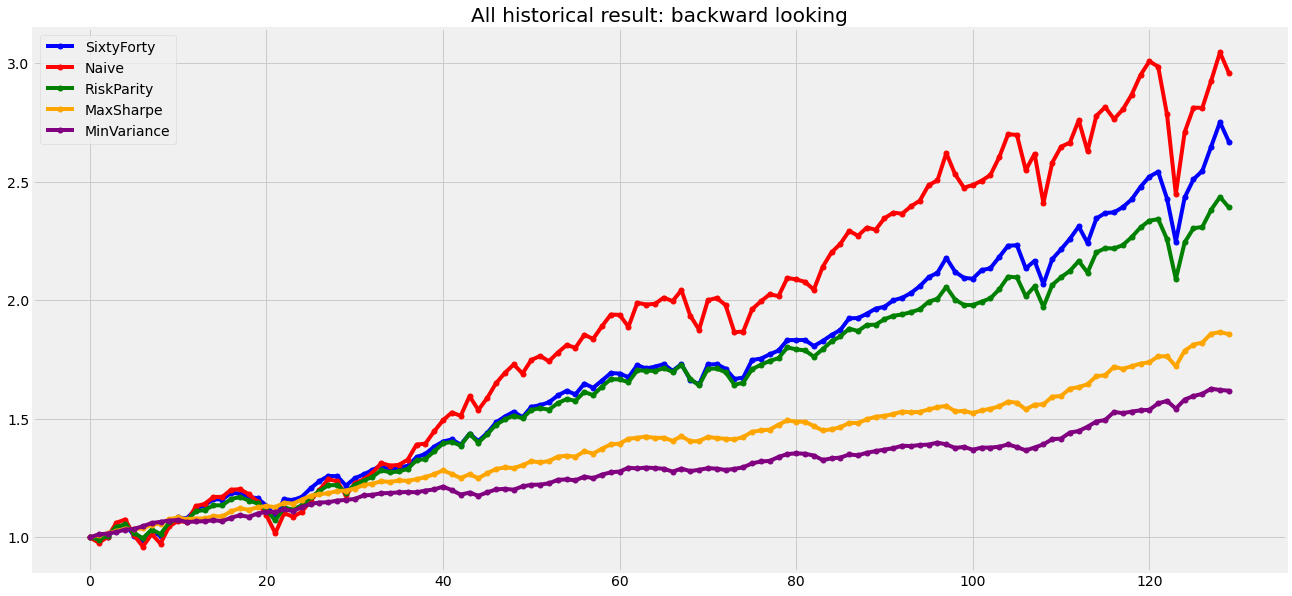

In [164]:
newPortFolioAll = StrategyBackTest(df_norf, rf)
newPortFolioAll.backTest(1,df_norf, rf)
newPortFolioAll.plotPortfolio("All historical result: backward looking")

In [165]:
newPortFolioAll.calSharpe(rf)

SixtyForty     1.092537
Naive          0.855806
RiskParity     1.062344
MaxSharpe      1.651640
MinVariance    1.504964
dtype: float64

Q1 :Mean Variance trade-off for entire

In [166]:
simulated_All = SimulatePortfolio(df_norf,rf)

In [167]:
simulated_All.random_portfolio()

(matrix([[0.1037209]]), matrix([[0.12255695]]))

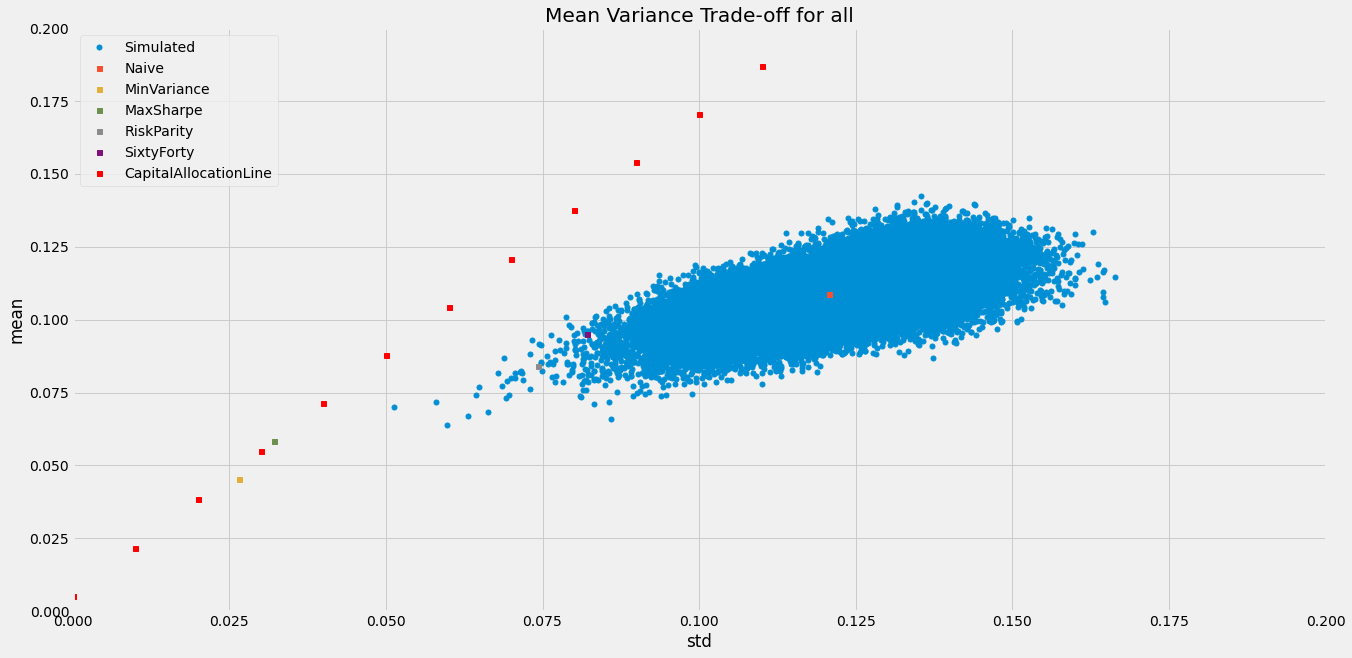

In [168]:
simulated_All.plotSimulated("Mean Variance Trade-off for all", newPortFolioAll)

Q2: Only use five years data;
Q3: Back test result;

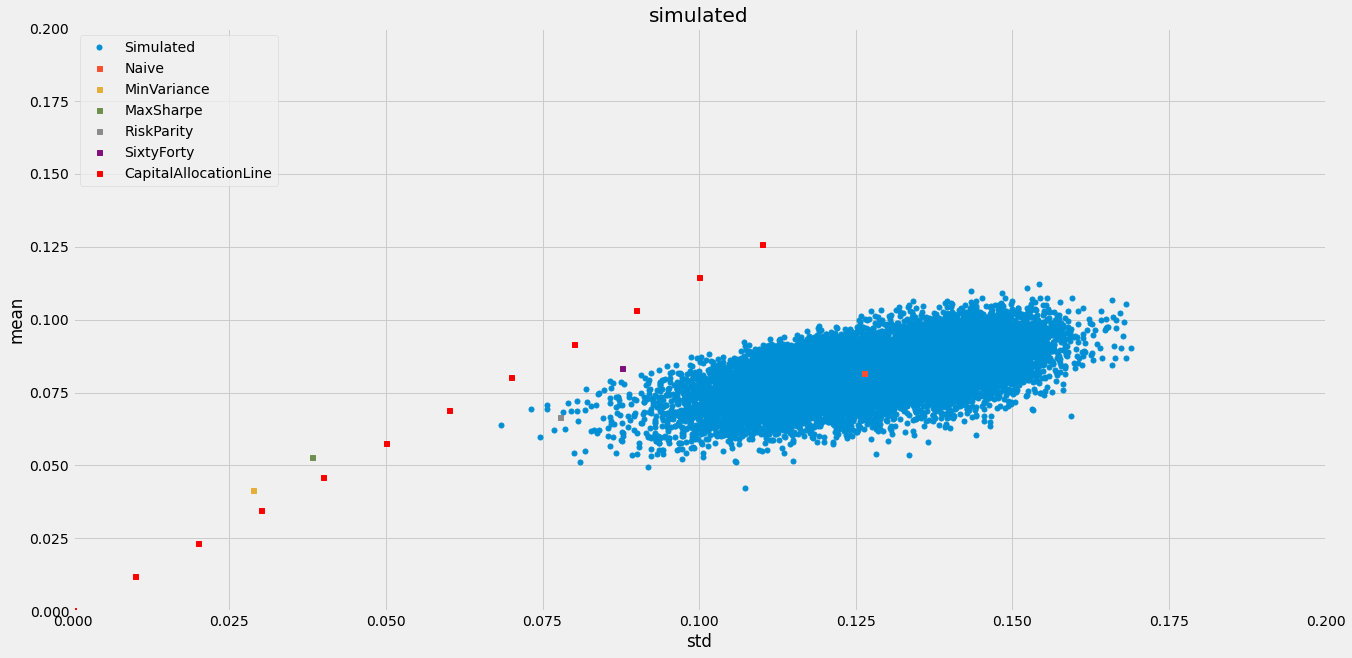

In [ ]:
newPortFolio = StrategyBackTest(df_norf_five, rf_five)
newPortFolio.backTest(100, df_norf_af,rf_af)
sp = SimulatePortfolio(df_norf_af, rf_af)
sp.plotSimulated("simulated", newPortFolio)


In [ ]:
newPortFolio.calSharpe(rf_af)

SixtyForty     0.844169
Naive          0.572906
RiskParity     0.734015
MaxSharpe      1.140125
MinVariance    1.124780
dtype: float64

In [ ]:
newPortFolio.maxSharpe

1.1401247086186042

Q3: Back test result

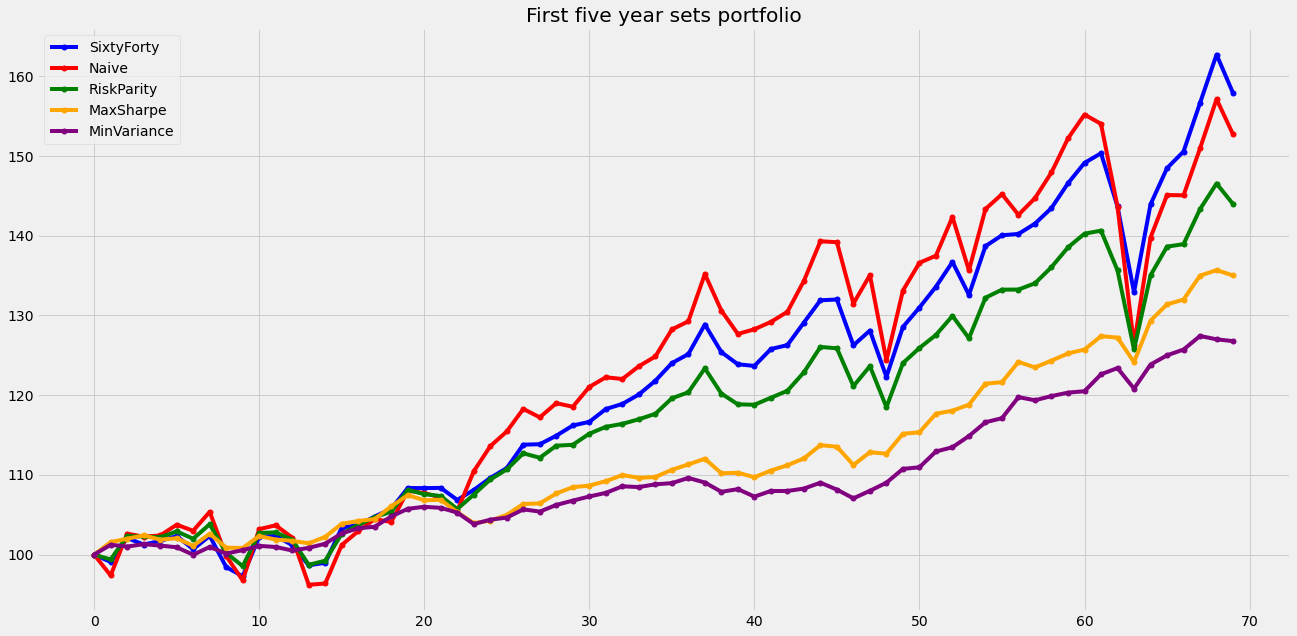

In [ ]:
newPortFolio.plotPortfolio("First five year sets portfolio")


Q4: rebalance weight each year?

In [ ]:
class StrategyBackTest(object):

    def __init__(self, returnInput, riskFreeRate):
      self.returnInput = returnInput
      self.expectedReturn = [(riskFreeRate + i*0.01) for i in range(16)]
      self.riskFreeRate = riskFreeRate

      # weight setup
      self.wt_sixtyForty = [0.4, 0.6, 0, 0, 0, 0, 0]
      self.wt_naive = [1/7]*7
      self.wt_maxSP = []
      self.wt_minVar = []
      self.wt_riskParity = []

    def getExpectedReturn(self):
        return self.expectedReturn

    def setExpectedReturn(self, newReturn):
        self.expectedReturn = newReturn
        
    def meanVarianceCal(self):
      """
      Return: annualized return and covariance matrix

      @param: input table of monthly return data

      """
      mu = (self.returnInput.mean()*12).T
      S  = np.asmatrix(np.cov(self.returnInput.T))*12
      return mu, S

    def dToL(self,dict):
      """
        Return list from Dict
        @param: dict from calculated weight of ef model
      """
      returnList = []
      for key in dict.keys():
        returnList.append(dict[key])
      return returnList

    def dictToList(self, dict):
      """
        Return list from Dict
        @param: dict from calculated weight of ef model
      """
      returnList = []
      for key in dict.keys():
        returnList.append(dict[key])
      return np.asmatrix(returnList)


    def exp_portfolio(self,returnInput,weight):  
        '''  
        Returns the mean and standard deviation of returns for a random portfolio  
        '''
        returns = returnInput.T
        p = np.asmatrix(np.mean(returns, axis=1))*12  
        w = np.asmatrix(weight)  
        C = np.asmatrix(np.cov(returns))*12  
        mu = w * p.T  
        sigma = np.sqrt(np.dot(np.dot(w,C), w.T))  
        # # This recursion reduces outliers to keep plots pretty  
        # if sigma > 2:  
        #     return random_portfolio(returns)  
        return mu, sigma

    def calculateSigma(self, ef):
        sigmaList = []
        for ret in self.getExpectedReturn():
          nWeight = ef.efficient_return(ret)
          lWeight = dictToList(nWeight)
          expReturn, expSigma = exp_portfolio(lWeight)
          sigmaList.append(expSigma[0].item())
        return sigmaList

    def riskParityWeight(self):
        """
        Return risk party weight
        @param df: monthly return data
        """
        monthly_std = np.std(self.returnInput, axis = 0, ddof = 1)
        wt_rp = (1/(monthly_std*np.sqrt(12)))/(1/(monthly_std*np.sqrt(12))).sum()
        return wt_rp


    def modelTrain(self):

        mu, S = self.meanVarianceCal() # calculate mean variance
        ef = EfficientFrontier(mu,S)  # get the efficient frontier
        self.wt_maxSP =self.dToL(ef.max_sharpe(risk_free_rate = self.riskFreeRate))
        ef = EfficientFrontier(mu,S)
        self.wt_minVar = self.dToL(ef.min_volatility())
        self.wt_riskParity = self.riskParityWeight()


    def strategySetup(self):

        self.modelTrain()
        strategyDict = {
            "SixtyForty": self.wt_sixtyForty,
            "Naive": self.wt_naive,
            "RiskParity": self.wt_riskParity,
            "MaxSharpe": self.wt_maxSP,
            "MinVariance": self.wt_minVar
        }
        return strategyDict

    def calReturn(self, amt, ann_df, wt):
        sumList = []
        sumList.append(amt) # append the total
        for iter in range(len(ann_df)):
          amt = (ann_df.iloc[iter] * np.asarray(wt)*amt).sum()
          sumList.append(amt)
        return sumList


    def backTest(self, totalAmount, test_df, test_rf):
        """
        Return : A dictionary containing return based on all the strategies
        @param: totalAmount, initial amount to invest
        @param: test_df -> input return period
        """
        strategyDict = self.strategySetup()
        ann_df = 1 + test_df
        resultDict = {}
        for key in strategyDict.keys():
          resultDict[key] = self.calReturn(totalAmount, ann_df, strategyDict[key])
        portfolioRec = pd.DataFrame(resultDict)
        portfolioRec['Period'] =range(0, len(resultDict['Naive']))
        self.length = len(resultDict['Naive'])
        self.portfolioRec = portfolioRec
        self.strategyMeanStd(self.returnInput)
        sharp = self.calSharpe(test_rf)
        self.maxSharpe = sharp['MaxSharpe']
        # maxSharpe via 5 year record or via back test result?
        # self.maxSharpe = (self.muMaxSP.item(0) - self.riskFreeRate)/(self.SMaxSP.item(0))
        self.capitalAllocation()

    def plotPortfolio(self, title = "Back Test Result"):
        plt.figure(figsize=(20,10))
        plt.style.use('fivethirtyeight')
        plt.plot('Period','SixtyForty', data=self.portfolioRec, marker='o', markerfacecolor='blue', markersize=5, color='blue', linewidth=4)
        plt.plot('Period','Naive', data=self.portfolioRec, marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=4)
        plt.plot('Period','RiskParity', data=self.portfolioRec, marker='o', markerfacecolor='green', markersize=5, color='green', linewidth=4)
        plt.plot('Period','MaxSharpe', data=self.portfolioRec, marker='o', markerfacecolor='orange', markersize=5, color='orange', linewidth=4)
        plt.plot('Period','MinVariance', data=self.portfolioRec, marker='o', markerfacecolor='purple', markersize=5, color='purple', linewidth=4)
        plt.title(title)
        plt.legend(loc='upper left')

    def calSharpe(self, riskFreeRate):
        """
        Return the calculated sharpe ratio for each strategy with back tested data
        All values are calculated with back test result

        """
        returnMatrix = self.portfolioRec.pct_change()[1: self.length].drop(['Period'], axis = 1)
        return ((returnMatrix.mean()*12- riskFreeRate)/(returnMatrix.std()*np.sqrt(12)))

    def strategyMeanStd(self,test_df):
        self.muSF, self.SSF = self.exp_portfolio(test_df, self.wt_sixtyForty)
        self.muMaxSP, self.SMaxSP = self.exp_portfolio(test_df,self.wt_maxSP)
        self.muNaive, self.SNaive = self.exp_portfolio(test_df, self.wt_naive)
        self.muMinVar, self.SMinVar = self.exp_portfolio(test_df, self.wt_minVar)
        self.muRP, self.SRP = self.exp_portfolio(test_df, self.wt_riskParity)

    def capitalAllocation(self):
        self.stdev_cal = [0.01*i for i in range(12)]
        self.r_cal = [self.riskFreeRate + self.maxSharpe*std for std in self.stdev_cal]
     
    def getMaxSharpe(self):
        return self.maxSharpe

Q6: You can't charge much since the simple 60%/40% portfolio out performs the balancing strategy